In [3]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

    


device = 'cuda:0'


# Non masked

In [5]:

model = torch.load(
"./results/trained_pytorch_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_27-10-2022_16h_22min_best_ValAcc_0.988306299509619_epoch_9.pt")
#loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt"
loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt"
loader = torch.load(loader_path)
#loader_validation = loader.get_validation_loader()
loader_train = loader.get_train_loader()
############################
##############################
explainer  = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
model.to(device, non_blocking=True)
#a_batch = next(iter(loader_validation)).to(device, non_blocking=True)




GIN_classifier_to_explain_v2(
  (GIN_layers): GIN(1, 8, num_layers=2)
  (FC1): Linear(in_features=8, out_features=1, bias=True)
  (FC2): Linear(in_features=11264, out_features=tensor([2]), bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

In [6]:

model.eval()
gc.collect()
torch.cuda.empty_cache() 
edge_num           = loader_train.dataset[0].edge_index.shape[1]
all_graphs_weights = []#torch.empty(edge_num,1).to(device)

for graph in loader_train.dataset:
    _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
    
    #all_graphs_weights = torch.cat((all_graphs_weights, edge_weights.reshape(edge_num,1).to(device)), dim=1)
    all_graphs_weights.append(edge_weights.reshape(edge_num,1))
    


Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 594.90it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

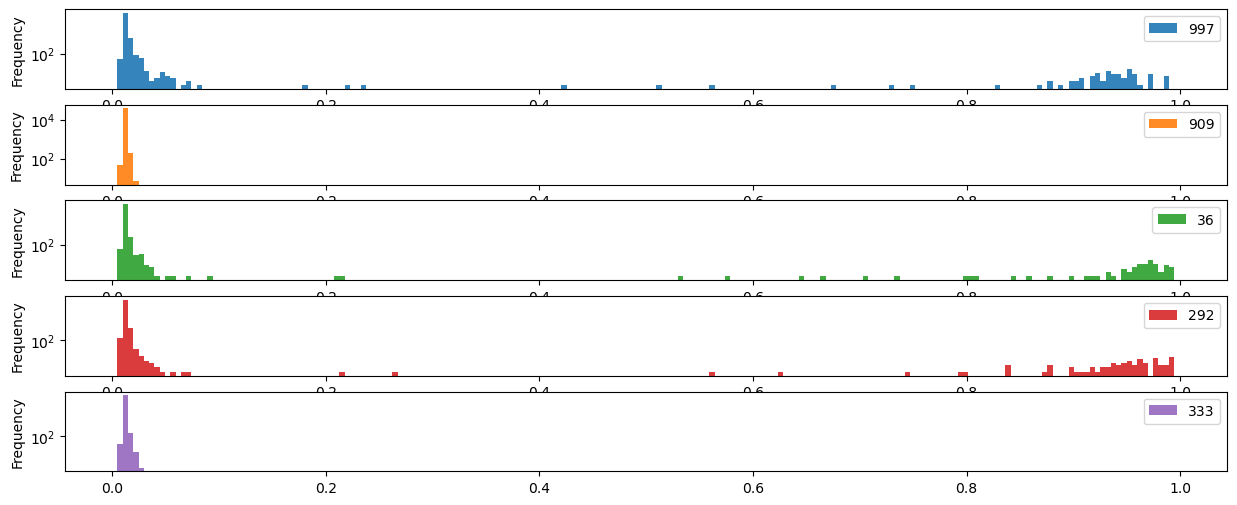

In [8]:
import numpy as np
all_graphs_weights_df = pd.DataFrame(
torch.stack(all_graphs_weights,1).squeeze().cpu().numpy())



all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)


In [9]:
train_labels = []
for graph in tqdm.tqdm(loader_train.dataset):
    train_labels.append(graph.y.cpu().item())
assert train_labels.__len__() == all_graphs_weights_df.shape[1]
#all_graphs_weights.shape

labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
labels
pd.Series(labels).to_csv("./results/data/data_for_R/Non_Masked_train_labels.csv")


100%|██████████| 4921/4921 [00:00<00:00, 630349.68it/s]


In [10]:
all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]

all_graphs_weights_df.to_parquet('./results/data/data_for_R/Non_masked_graphs_weights_from_explainer.parquet.gzip', compression = 'gzip')



all_graphs_weights_df.columns = [float(col) for col in all_graphs_weights_df.columns]


all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)



all_graphs_weights_df.stack().reset_index(drop=True).plot.hist(bins=500, logy = True, figsize=(7,2.8), grid=False, color = 'blue', alpha=.8)
plt.xlabel('Edge weight')
plt.tight_layout()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.9, alpha=.5)
#plt.xlim([0, 1])
plt.legend(['Control'])
plt.show()


all_graphs_weights_df.min().plot.hist(logy = True, bins=500)


all_graphs_weights_df.max().plot.hist(logy = True, bins=500)


filtered_graph_weights = filtered_graph_weights_df.transpose() #.columns = train_labels
filtered_graph_weights["Label"] = ["PKU" if l == 0 else "Control" for l in train_labels] 


filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights.to_parquet('./results/data/filtered_graph_weights.parquet.gzip', compression = 'gzip')

edge_0_node_idxs =  pyg_graph.edge_index[0,:]
edge_1_node_idxs =  pyg_graph.edge_index[1,:]
edge_0_nodes     = [list(nx_G.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(nx_G.nodes)[i] for i in  edge_1_node_idxs]

edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, explainer_subgraphs_df], axis=1)

edge_num           = loader_train.dataset[0].edge_index.shape[1]
model.eval()
gc.collect()
torch.cuda.empty_cache() 


import ray
ray.shutdown()
ray.init()
@ray.remote



def get_edge_weights(x, edge_index,edge_num):
    _ , edge_weights =  explainer.explain_graph(x,edge_index)
    return edge_weights.reshape(edge_num,1)
        
        
g = []        
for graph in loader_train.dataset:
    g.append(get_edge_weights.remote(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True), edge_num))


    
all_graphs_weights = pd.Series(ray.get(g) , name='genes')
